# 03-202 : Question 5 Model

Train a model specifically for question 5, and then use it in conjunction with `simple_monkey` to predict the entire dataset and get a classification report.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import logging
from typing import List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow

import tensorflow_addons as tfa
import keras as k
from keras import optimizers
import keras_tuner
import keras_tuner as kt

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from competition import data_preparation as dp
from competition import feature_engineering as fe
from competition import model_data as md
from competition import source_data as sd
import competition.models.simple_dense as sd_model
from competition.models.heatmap_covnet import HeatmapCovnetModel

from competition.model_training import mprint, mflush, mclear
from competition.predict import PredictionBase, Baseline

2023-04-09 14:40:56.189422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Configure Logging

In [3]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-04-09 14:40:57 INFO     Started


## Data Collection

In [4]:
# load the source training set
df_source = sd.read_csv('../data/train.csv.gz',
                        compression='gzip',
                        dtype=sd.source_dtype)

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [5]:
# load the source training labels
df_source_labels = sd.read_csv('../data/train_labels.csv')

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Data Preparation & Cleaning

In [6]:
# prepare the main dataset
df_source = dp.prepare_main_dataset(df_source,
                                    elapsed_time_min_clip=0,
                                    elapsed_time_max_clip=3691298)

# remove sessions with problems
problem_sessions = dp.find_problem_sessions(df_source)
df_source = df_source[~df_source['session_id'].isin(problem_sessions)]

In [7]:
# prepare the label dataset
df_source_labels = dp.prepare_label_dataset(df_source_labels)

# remove sessions with problems
df_source_labels = df_source_labels[~df_source_labels['session_id'].isin(problem_sessions)]

## Feature Engineering

Instead of duplicating the feature engineering workflow, we will use the same feature dataset created in notebook `03-123`.

In [8]:
df_features = pd.read_pickle(
    'data/features/03-123.parquet',
    compression='gzip')

with pd.option_context('display.max_columns', None):
    display(df_features.head(3))

,session_id,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode,count_total_event_name,count_total_name,count_total_fqid,count_total_room_fqid,count_total_text_fqid,count_unique_event_name,count_unique_name,count_unique_fqid,count_unique_room_fqid,count_unique_text_fqid,screen_heatmap_feature
0,20090312431273200,0-4,0.001411,0.052535,0.000000,0.023103,0.000000,0.088782,0.088782,0.064620,0.088782,0.054054,0.75,0.0,0.203390,0.090909,0.225,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,20090312431273200,13-22,0.043740,0.344602,0.226677,0.281804,0.301320,0.394721,0.394721,0.402262,0.394721,0.480127,0.75,0.0,0.525424,0.545455,0.675,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,20090312431273200,5-12,0.010577,0.135014,0.060002,0.096641,0.060002,0.245951,0.245951,0.276252,0.245951,0.257552,0.75,0.0,0.355932,0.454545,0.400,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


## Data Selection

We first combine the features with the labels as we will do data selection now based on question number as opposed to to all previous notebooks.

In [9]:
df_combined = df_source_labels.merge(
    right=df_features, 
    on=['session_id', 'level_group'],
    how='left')

print(df_combined.shape)
with pd.option_context('display.max_columns', None):
    display(df_combined.head(6))

(209664, 20)


,session_id,question_num,correct,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode,count_total_event_name,count_total_name,count_total_fqid,count_total_room_fqid,count_total_text_fqid,count_unique_event_name,count_unique_name,count_unique_fqid,count_unique_room_fqid,count_unique_text_fqid,screen_heatmap_feature
0,20090312431273200,1,1,0-4,0.001411,0.052535,0.0,0.023103,0.0,0.088782,0.088782,0.064620,0.088782,0.054054,0.75,0.000000,0.203390,0.090909,0.225,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,20090312433251036,1,0,0-4,0.001352,0.063074,0.0,0.026311,0.0,0.057588,0.057588,0.053312,0.057588,0.050874,1.00,0.333333,0.067797,0.000000,0.075,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,20090314121766812,1,1,0-4,0.002928,0.106324,0.0,0.047996,0.0,0.088782,0.088782,0.066236,0.088782,0.044515,1.00,0.333333,0.135593,0.090909,0.175,"[[[0.05882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
3,20090314363702160,1,1,0-4,0.001627,0.058690,0.0,0.030143,0.0,0.065987,0.065987,0.050081,0.065987,0.034976,0.50,0.000000,0.050847,0.090909,0.075,"[[[0.05882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
4,20090314441803444,1,1,0-4,0.000824,0.047682,0.0,0.020862,0.0,0.019196,0.019196,0.025848,0.019196,0.022258,0.50,0.000000,0.067797,0.090909,0.050,"[[[0.05882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
5,20090315081004164,1,0,0-4,0.002515,0.092231,0.0,0.036151,0.0,0.116377,0.116377,0.096931,0.116377,0.063593,0.75,0.000000,0.118644,0.090909,0.150,"[[[0.05882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."


Create a function that will combine the datasets like we just did above and then return the dataset for the specified question.

In [10]:
# test the function
df_question_features, df_question_labels = md.get_question_dataset(features=df_features,
                                                                labels=df_source_labels,
                                                                question_num=10)

2023-04-09 14:41:32 INFO     Temporarily removing the "screen_heatmap_feature" column
2023-04-09 14:41:32 INFO     Adding back the "screen_heatmap_feature" column


Split the data into training and test sets.

In [11]:
random_state = 51

In [12]:
# split the dataset into train, validation and test sets
train, val, test = md.select_sessions(
    y=df_question_labels,
    random_state=random_state,
    test_size=0.60,
    train_size=0.75)

Train: 3495
Validation: 1165
Test: 6988


## Model Training

### Create Datasets

In [13]:
# set the feature list
feature_list = ['elapsed_time_sum', 'elapsed_time_max', 'elapsed_time_min', 'elapsed_time_mean', 'elapsed_time_mode']

# create the simple model dataset
features_dataset = md.get_feature_dataset(
    features=df_question_features,
    y=df_question_labels,
    feature_list=feature_list,
    train=train,
    val=val,
    test=test,
    include_question=True,
    expand_question=False)

2023-04-09 14:41:33 INFO     -- Creating the train dataset
2023-04-09 14:41:33 INFO     Creating the dataset for all level groups


  0%|          | 0/3495 [00:00<?, ?it/s]

2023-04-09 14:41:38 INFO     -- Creating the val dataset
2023-04-09 14:41:38 INFO     Creating the dataset for all level groups


  0%|          | 0/1165 [00:00<?, ?it/s]

2023-04-09 14:41:40 INFO     -- Creating the test dataset
2023-04-09 14:41:40 INFO     Creating the dataset for all level groups


  0%|          | 0/6988 [00:00<?, ?it/s]

In [14]:
# convert the labels for multi-label classification
cat_features_dataset = md.labels_to_categorical(features_dataset)

In [15]:
# get the shape of the question only dataset
input_data = cat_features_dataset['train']['X']
features_dataset_shape = input_data.shape[1]
print('features_dataset_shape:', features_dataset_shape)

# define the output shape
output_data = cat_features_dataset['train']['y']
output_shape = output_data.shape[1]
print('output_shape', output_shape)

features_dataset_shape: 23
output_shape 2


### Flat Features Only

In [16]:
# configure mlflow
mlflow.set_experiment("question-10-simple")
mlflow.keras.autolog()

In [17]:
mlflow.end_run()

In [18]:
# create the hyperparameter object
def define_tune_parameters(hp):
    hp.Int('dense_layer_count', min_value=1, max_value=6, step=1)
    hp.Int('dense_units', min_value=512, max_value=1700, step=32)
    hp.Choice('dense_activation', values=['relu', 'tanh', 'LeakyReLU'])
    hp.Float('dense_l1_regularization', min_value=0.0, max_value=0.0005, step=0.00001)
    hp.Float('dense_l2_regularization', min_value=0.0, max_value=0.001, step=0.0001)
    hp.Float('dense_dropout', min_value=0.005, max_value=0.1, step=0.005)
    hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6])

Trial 29 Complete [00h 00m 06s]
val_f1_score: 0.6532875299453735

Best val_f1_score So Far: 0.6664831638336182
Total elapsed time: 00h 03m 14s
2023-04-09 14:45:06 INFO     on_trial_begin


/root/miniconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



Search: Running Trial #30

Value             |Best Value So Far |Hyperparameter
6                 |2                 |dense_layer_count
608               |512               |dense_units
tanh              |LeakyReLU         |dense_activation
5e-05             |0.00036           |dense_l1_regularization
0.0009            |0                 |dense_l2_regularization
0.02              |0.06              |dense_dropout
0.001             |0.0001            |learning_rate

2023-04-09 14:45:06 INFO     Creating simple dense model
Epoch 1/2000
1/7 [===>..........................] - ETA: 2s - loss: 6.7455 - f1_score: 0.6430WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_train_batch_end` time: 0.0027s). Check your callbacks.
2023-04-09 14:45:07 WARNING  Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_train_batch_end` time: 0.0027s). Check your callbacks.
7/7 [================

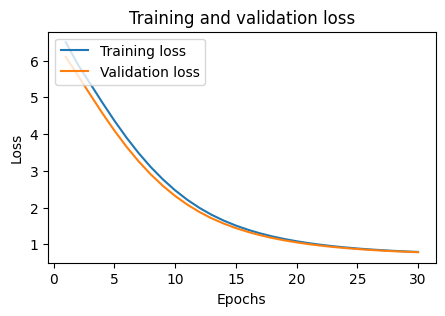

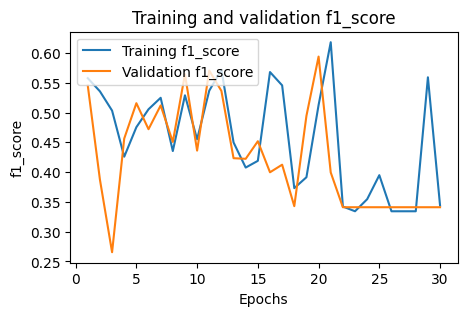

146/146 [==============================] - 0s 668us/step


#### Threshold: 0.5
```
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00      3512
         1.0       0.50      1.00      0.66      3476

    accuracy                           0.50      6988
   macro avg       0.75      0.50      0.33      6988
weighted avg       0.75      0.50      0.33      6988

```

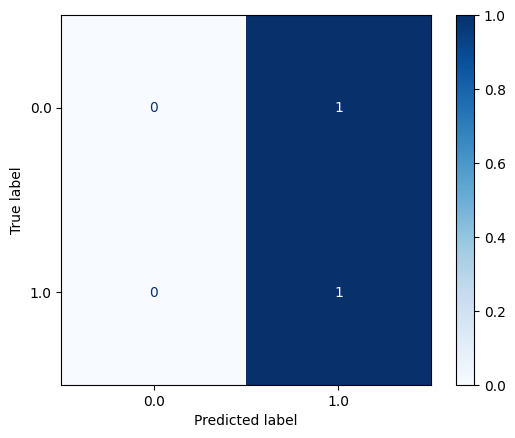

In [19]:
# find the best model
for batch_size in [500, 1000, 2000, 3000, 4000]:
    for optimizer in [optimizers.Adam, optimizers.RMSprop]:
        sd_model.tune_model(
            define_tune_parameters=define_tune_parameters,
            dataset=cat_features_dataset,
            max_trials=50,
            input_shape=features_dataset_shape,
            output_shape=output_shape,
            dense_layer_count='dense_layer_count',
            dense_units='dense_units',
            dense_activation='dense_activation',
            dense_l1_regularization='dense_l1_regularization',
            dense_l2_regularization='dense_l2_regularization',
            dense_dropout='dense_dropout',
            train_epochs=2000,
            train_batch_size=batch_size,
            train_optimizer=optimizer,
            train_learning_rate='learning_rate',
            train_loss='categorical_crossentropy',
            train_metrics=[tfa.metrics.F1Score(name='f1_score', num_classes=2, threshold=0.5, average='macro')],
            train_class_weight=None,
            tune_objective='val_f1_score',
            tune_direction='max',
            tuner_type=kt.tuners.BayesianOptimization,
            tune_patience=10)

### Combined Features

In [ ]:
# configure mlflow
mlflow.set_experiment("question-10-heatmap")
mlflow.keras.autolog()

In [ ]:
# create the heatmap dataset
heatmap_dataset = md.get_feature_dataset(
    features=df_question_features,
    y=df_question_labels,
    feature_list=['screen_heatmap_feature'],
    train=train,
    val=val,
    test=test,
    include_question=False,
    expand_question=False)

In [ ]:
# define the flat heatmap input shape
input_data = heatmap_dataset['train']['X']
heatmap_shape = input_data.shape[1], input_data.shape[2], input_data.shape[3]
print('heatmap_shape:', heatmap_shape)

# get the shape of the question only dataset
input_data = cat_features_dataset['train']['X']
features_dataset_shape = input_data.shape[1]
print('features_dataset_shape:', features_dataset_shape)

# define the output shape
output_data = cat_features_dataset['train']['y']
output_shape = output_data.shape[1]
print('output_shape', output_shape)

In [ ]:
# define the tuner parameters
def define_heatmap_tune_parameters(hp):
    # add the simple model parameters
    define_tune_parameters(hp)

    # add the heatmap model parameters
    hp.Int('covnet_block_count', min_value=1, max_value=3, step=1)
    hp.Choice('covnet_activation', values=['relu', 'tanh', 'LeakyReLU'])
    hp.Int('covnet_cov_count', min_value=1, max_value=3, step=1)
    hp.Int('covnet_channels', min_value=32, max_value=64, step=16)
    hp.Choice('covnet_kernel_size', values=['(3, 3)'])
    hp.Choice('covnet_pool_size', values=['(2, 2)'])

In [ ]:
# create the model object
heatmap_model = HeatmapCovnetModel(
    input_shape=features_dataset_shape,
    heatmap_shape=heatmap_shape,
    output_shape=output_shape,
    loss='categorical_crossentropy',
    metrics=[tfa.metrics.F1Score(name='f1_score', num_classes=2, threshold=0.5, average='macro')])

In [ ]:
mlflow.end_run()

In [ ]:
# find the best model
for batch_size in [500, 1000, 2000, 3000, 4000]:
    for optimizer in [optimizers.Adam, optimizers.RMSprop]:
        model = heatmap_model.tune_model(
            define_tune_parameters=define_heatmap_tune_parameters,
            heatmap_dataset=heatmap_dataset,
            feature_dataset=cat_features_dataset,
            max_trials=50,
            train_epochs=1000,
            train_batch_size=batch_size,
            train_optimizer=optimizer,
            tuner_type=kt.tuners.BayesianOptimization,
            tune_objective='val_f1_score',
            tune_direction='max',
            train_class_weight=None,
            tune_patience=10)
        
        mlflow.end_run()

### Save the best model

In [ ]:
# load the best model from mlflow
model_uri = "runs:/c17ac7db56ea455e867a93e76e473270/model"
q10_model = mlflow.keras.load_model(model_uri)

# save the model to disk
k.models.save_model(q10_model, "../data/interim/model_03-203.h5")

## Model Evaluation

In [ ]:
# load the test session ids
test = np.load('../data/interim/test_03-202.npy')

# load the model
q10_model = k.models.load_model('../data/interim/model_03-203.h5')

In [ ]:
# select all the records in the training set
df_test = df_source[df_source.session_id.isin(test)]

# select the last record for each session
df_test_labels = df_source_labels[df_source_labels.session_id.isin(test)]

### Create Predictor

In [ ]:
class Predictor(Baseline):
    """
    Use the best model for question 5 to predict the correct labels.
    """

    def __init__(self, model_q5, threshold_q5):
        # call the base class constructor
        super().__init__()

        # initialize the models collection
        self.models = {}
        self.thresholds = {}

        # add the model to the collection
        self.models[5] = model_q5
        self.thresholds[5] = threshold_q5

    def feature_engineering(self, data:pd.DataFrame, labels:pd.DataFrame) -> List[pd.DataFrame]:
        """
        This method is used to perform feature engineering on the data.
        """
        # create the initial features
        df_features = fe.create_initial_features(data, labels)

        # add the elapsed time feature to the features dataset
        df_features = fe.add_elapsed_time_features(
            features=df_features,
            X=data)

        # add the total count features to the features dataset
        df_features = fe.add_count_total_features(
            features=df_features,
            X=data)

        # add the unique count features to the features dataset
        df_features = fe.add_count_unique_features(
            features=df_features,
            X=data)    

        # add the heatmap features to the features dataset
        df_features = fe.add_screen_heatmap_feature(
            features=df_features,
            X=df_source,
            verbose=False)

        # create the flat features dataset
        features_dataset = md.create_feature_dataset(
            df_features=df_features,
            df_source_labels=labels,
            session_list=labels.session_id.unique(),
            feature_list=['elapsed_time_sum', 'elapsed_time_max', 
                          'elapsed_time_min', 'elapsed_time_mean', 
                          'elapsed_time_mode'],
            include_question=True,
            expand_question=False,
            verbose=False)

        # create the heatmap features dataset
        heatmap_dataset = md.create_feature_dataset(
            df_features=df_features,
            df_source_labels=labels,
            session_list=labels.session_id.unique(),
            feature_list=['screen_heatmap_feature'],
            include_question=False,
            expand_question=False,
            verbose=False)

        return [heatmap_dataset, features_dataset]


    def predict_question(self, feature_set:List[pd.DataFrame], question_num:int) -> int:
        """
        Predict the correct answer for the given question.

        Parameters
        ----------
        feature_set : List[pd.DataFrame]
            The list of feature sets for the questions.
        question_num : int
            The question number to predict.

        Returns
        -------
        int
            The predicted answer for the question.
        """
        # if no model is defined for the question, use the base class
        model = self.models.get(question_num, None)
        threshold = self.thresholds.get(question_num, None)

        if model is None:
            return super().predict_question(feature_set, question_num)

        # use the model for prediction
        y_pred_model = model.predict(feature_set, verbose=0)
        y_pred_model = (y_pred_model[:, 1] > threshold).astype(int)

        return y_pred_model[0]
disp = ConfusionMatrixDisplay.from_predictions(
#     y_true=y_true, 
#     y_pred=y_pred_baseline,
#     cmap=plt.cm.Blues,
#     normalize='true')
# plt.show()

# disp = ConfusionMatrixDisplay.from_predictions(
#     y_true=y_true, 
#     y_pred=y_pred_model,
#     cmap=plt.cm.Blues,
#     normalize='true')
# plt.show()
predictor = Predictor(q5_model, 0.52)
#feature_set = predictor.feature_engineering(df_test, df_test_labels)


### Question 5

In [ ]:
# select the data labels for only question 5
df_q5_labels = df_test_labels[df_test_labels.question_num == 5]
q5_level_groups = df_q5_labels.level_group.unique()

# select the source data for question 5
df_q5 = df_test[df_test.level_group.isin(q5_level_groups)]

In [ ]:
# get the test data labels
y_true = df_q5_labels['correct']

In [ ]:
# perform the predictions
base_model:Baseline = Baseline()
df_q5_baseline = base_model.predict(data=df_q5, labels=df_q5_labels)
y_pred_baseline = df_q5_baseline['correct']

In [ ]:
# perform predictions with the q5 model
q5_predictor:Predictor = Predictor(q5_model, 0.52)
df_q5_model = q5_predictor.predict(data=df_q5, labels=df_q5_labels)
y_pred_model = df_q5_model['correct']

In [ ]:
# show the classification report
mprint('#### Baseline')
mprint('```')
mprint(classification_report(y_true, y_pred_baseline, zero_division=0))
mprint('```')

mprint('#### Model')
mprint('```')
mprint(classification_report(y_true, y_pred_model, zero_division=0))
mprint('```')

mflush()

### All Questions

In [ ]:
# get the test data labels
y_true = df_test_labels['correct']

In [ ]:
# perform the baseline predictions
base_model:Baseline = Baseline()
df_baseline = base_model.predict(data=df_test, labels=df_test_labels)
y_pred_baseline = df_baseline['correct']

In [ ]:
# perform predictions with the model
q5_predictor:Predictor = Predictor(q5_model, 0.52)
df_model = q5_predictor.predict(data=df_test, labels=df_test_labels)
y_pred_model = df_model['correct']

In [ ]:
# show the classification report
mprint('#### Baseline')
mprint('```')
mprint(classification_report(y_true, y_pred_baseline, zero_division=0))
mprint('```')

mprint('#### Model')
mprint('```')
mprint(classification_report(y_true, y_pred_model, zero_division=0))
mprint('```')

mflush()

# disp = ConfusionMatrixDisplay.from_predictions(
#     y_true=y_true, 
#     y_pred=y_pred_baseline,
#     cmap=plt.cm.Blues,
#     normalize='true')
# plt.show()

# disp = ConfusionMatrixDisplay.from_predictions(
#     y_true=y_true, 
#     y_pred=y_pred_model,
#     cmap=plt.cm.Blues,
#     normalize='true')
# plt.show()
